# Supplementary Source Code 2 – Crop Image Selection

This Jupyter notebook describes the automated image selection algorithm and associated libraries that can function on a PC or a HPC cluster for selecting high-quality images from a given time-lapse crop image series captured by infield CropQuant workstations.    

Based on the Jupyter server, we provide an interactive environment to facilitate libraries imports, our tailored and modulated functions, automated image processing and phenotypic analysis outputs for reviewers and end-users to: 

* Execute codes and associated maths and feature extraction models
* Generate plots and present intermediate processing results  
* Batch process a given crop image series for quality control. 


## Please note that:
1. A Jupyter notebook is ONLY used for demonstrating the algorithm, NOT for batch processing big crop image series. 
2. The performance of the algorithm provided for the CropQuant breeding project could be varied due to an end-user's computing resources such as physical memory and CPU speed. 
3. Users might encounter issues with specific libraries if they have not installed properly or not been optimised for Linux-based operating systems. 
4. We recommend users to preinstall the latest open Anaconda Python distribution before using functions and modules in the CropQuant analysis pipeline that requires Scikit-image or Scikit-learning functions.   


In [1]:
#################################################################
#                                                               #
#    Author: Dr Ji Zhou (周济), ji.zhou@tgac.ac.uk               # 
#    Date: 6th June 2015                                        #
#    Version: 0.1 on TGAC internal Github                       #
#    Current Version: 1.02 on BitBucket                         #
#    SciPy version: 0.17.0, Scikit-image: 0.12.3                #
#    OpenCV version: 2.4.11, Sklearn: 0.17.1                    #
#                                                               #
#    Software license: the bespoke CropQuant Software License   # 
#    The algorithm below is developed by Dr Zhou and his team,  # 
#    which shall only be used for research purpose.             #
#                                                               #
#    Name: Crop Image Selection                                 #
#    Version changes:                                           #
#    1) Modulate the source code                                #
#    2) Update functions with the latest Anaconda distribution  #
#    3) Improve the dynamic measurement of quantifying the      #        
#    quality of images                                          #
#    4) Profile to optimse the selection performance            #
#                                                               #
#################################################################

#STEP 1: Import libraries 
% matplotlib inline
from matplotlib import pyplot as plt # Plotting
from skimage.color import rgb2gray
from skimage import io
import os # for access the file system
import math # for geometry analysis
import numpy as np
import gc # garbage collection

In [2]:
#STEP 2: Select image files and return full path 
##STEP 2.1: GUI dialog panel to locate where to read images 
import Tkinter, tkFileDialog

# make a top-level instance, but without displaying it
root = Tkinter.Tk() 
root.withdraw()
root.overrideredirect(True) 
# Almost invisible - no decorations, 0 size, top left corner.
root.geometry('0x0+0+0')
root.deiconify() # show window and lift it to top 
root.lift() # otherwise dialogs will place behind the terminal.
root.focus_force()

# Assign the selected filename with a full path
fullname = tkFileDialog.askopenfilename(parent=root)
# print str(fullname).replace(".jpg", "")
root.destroy() # get rid of the top-level instance 
# Finish read the full path from local file system


In [3]:
##STEP 2.2: Reassemble the directory of images 
# print fullname
# Genotype_CAM = Genotype_ID.split("_", 1)[0]
fullPath = fullname.split("/", -1) # change it to 1
fullPathRef = '/'.join(fullPath[: -1]) + '/' 
# mac or unix only, Windows should be
# fullPath = fullname.split("\\", -1) # change it to 1
# fullPathRef = '\\'.join(fullPath[: -1]) + '\\' 
print fullPathRef

/Users/zhouj/Documents/My papers/CropQuant/Submission/Supplementary/New Phytologist/Short_Images/


In [4]:
#STEP 3: Prepare file list for batch processing
import glob

##STEP 3.1: Based on GUI interaction, start reading all image files from the path
# The current working directory 
currentDir = os.getcwd()
# print currentDir
imgDirectory = fullPathRef
print imgDirectory

# pattern match jpg files
imageFiles = glob.glob(imgDirectory + "/*.jpg")
# Sort the image files based on create date
imageFiles.sort(key=os.path.getmtime)

# How many images that needs to go through in the folder
print len(imageFiles)

/Users/zhouj/Documents/My papers/CropQuant/Submission/Supplementary/New Phytologist/Short_Images/
242


In [5]:
##STEP 3.2: Set up result folders to contain the selected image files 
import time
from datetime import datetime, timedelta

# Current date and time
timeStamp = time.localtime(time.time())
curYear = timeStamp[0]
curMonth = timeStamp[1]
curDay = timeStamp[2]

# Assemble the result folder 
genotypeID = fullPath[-1].split('_', -1) 
print genotypeID
Result_Folder = genotypeID[0] + '_Refined_%d' %curDay + '-%d' %curMonth + '-%d' %curYear
Result_Directory = imgDirectory + Result_Folder

# If repeating the selection again with different criteria 
if not os.path.exists(Result_Directory):
    os.makedirs(Result_Directory)

print Result_Directory

['SHORT', 'CAM02', 'ID-01', 'Date-7-5-2015', '13-21.jpg']
/Users/zhouj/Documents/My papers/CropQuant/Submission/Supplementary/New Phytologist/Short_Images/SHORT_Refined_28-9-2017


In [6]:
import shutil

def copyImgFile(source, destination):
    try:
        shutil.copy2(source, destination) # Mate data will be included 
    # eg. src and dest are the same file
    except shutil.Error as e:
        print('Error: %s' % e)
    # eg. source or destination doesn't exist
    except IOError as e:
        print('Error: %s' % e.strerror)

In [7]:
from skimage import img_as_ubyte
from skimage import filters

def shadowMeasure(img):
    # Use illumination to define shadow on the picture 
    # tmp_lab = color.rgb2lab(img)
    tmp_gray = (img_as_float(img)) # illumination value
    global_thresh = filters.threshold_otsu(tmp_gray)
    if global_thresh * 0.4 > 25: 
        # shadow should be very dark with illum value below 25 
        global_thresh = 35 
    # Global thresholding to extract shadow regions     
    binary_global = tmp_gray < global_thresh * 0.225 # for very dark pixels 
    Dark_Percent = float(np.count_nonzero(binary_global))/float(binary_global.size)
    return Dark_Percent


In [8]:
#STEP 4: Select images based on the quality   

##STEP 4.1: Selection criteria based on brightness, clarity and file size  
from ipywidgets import widgets
from IPython.display import display 

# Widget 1 for file size
fileSizeText = widgets.BoundedFloatText( value=2.5, min=1.0, max=4.0, description='File_Size :', )
display(fileSizeText)

# Widget 2 for brightness
imageBrightness = widgets.Dropdown(options={'Cloudy': 1, 'Sunny intervals': 2, 'Sunshine': 3}, value=2,
    description='Weather :', )
display(imageBrightness)

# Widget 3 for clarity
imageClarity = widgets.Dropdown(options={'Low clarity': 1, 'Normal clarity': 2, 'High clarity': 3}, value=2,
    description='Clarity :', )
display(imageClarity)


In [9]:
# Read the input values 
print fileSizeText.value, imageBrightness.value, imageClarity.value

2.5 2 2


In [10]:
##STEP 4.2: Loop through images to select high quality images 

# Core selection algorithm starts from here
from skimage import color
from skimage import filters
from skimage import img_as_float
from skimage.transform import rescale
import csv


fileNo = 0 # File counter for going through the image directory 
imageSelected = False # Whether or not an image has been selected
imageID = 1 

# Testing the execution period
now_tmp_1 = datetime.now()
print now_tmp_1

###STEP 4.2.1: Save processing results in a csv file
# Create an empty csv file
cropSelectionFile = open(Result_Directory + "/" + "CropSelectionResults.csv", 'wb')
result_List = ["ID", "Date", "Img_hour", "Img_name", "Brightness", "Sharpness", "Shadow_percent"]
write_line = csv.writer(cropSelectionFile, delimiter=',', quoting=csv.QUOTE_ALL)
write_line.writerow(result_List)
cropSelectionFile.close()
print 'Finish creating ' + "CropSelectionResults.csv for saving selection results"
###############################################################################


###############################################################################
for fileNo in range(len(imageFiles)):
    
    # Start selecting images 
    # Select images based on imaging date and time
    img_name = imageFiles[fileNo].split("/", -1)[-1]
    imaging_Date = img_name.split("_")[3]
    imaging_Time = img_name.split("_")[-1]
    imaging_Month = imaging_Date.split("-")[2]
    imaging_Day = imaging_Date.split("-")[1]
    imaging_Hour = imaging_Time.split("-")[0]
    
    # The current imaging hour slot for comparing
    #if (current_imaging_hour != imaging_Hour):
    #    current_imaging_hour = imaging_Hour
    #    image_selected = False
    #    # Move onto the next imaging hour slot 
    
    ###############################################################################
    # image date and time
    print ("\t Start processing " + img_name) 
    # Read an image file 
    tmp_IMG_File = imageFiles[fileNo]
    tmp_img_buffer = io.imread(tmp_IMG_File)
    imageResize = rescale(tmp_img_buffer, 0.25) # 25% of the original size
    # Using hsv colour spacing value to judge the brightness of the image
    tmp_hsv_img = color.rgb2hsv(imageResize)
    tmp_value = tmp_hsv_img[:, :, 2]
    
    # Measure image brightness 
    #print(str(imageID) + ": (brightness) " + str(np.median(tmp_value)))
    if np.median(tmp_value) < (float(imageBrightness.value) + 1.5) * 0.1: 
        # threshold ranging from 0.3 to 0.5, over 0.5 will be a very sunny image
        continue # discard if the image is too dark or contain exposure issues
    
    # Measure image sharpness 
    image_sobel = filters.sobel(img_as_float(tmp_value)) 
    # Detection the size of edges on the given image 
    Sharpness_Measure = np.sum(image_sobel > 0.025)/(image_sobel.size * 1.0)
    # print(str(imageID) + ": (Sharpness) " + str(Sharpness_Measure))
    if Sharpness_Measure < (imageClarity.value + 2) * 0.125:
        # threshold ranging from 0.3 to 0.5, over 0.5 will be a sharp image 
        continue # discard if the image is too blur or out-of-focus
     
    # Measure shadow areas
    dark_percent = shadowMeasure(tmp_value)
    # print(str(imageID) + ": (dark_percent) " + str(dark_percent))
    if dark_percent > 0.20: # 20% of the image contains darker pixels 
        continue # too large shadow which shall not be used for analysis 
        
    # the size of the file
    file_stat = os.stat(tmp_IMG_File)
    filesize = 1.0 * file_stat.st_size/(1024**2) 
    # print filesize
    if filesize >= fileSizeText.value: # a good image normally has an image size of 3.0MB
        # This image is good to be selected
        # Organise the image path for file transfer
        # Transfer image to the new folder 
        print("\t" + str(imageID) +": (brightness) "+ str(round(np.median(tmp_value), 3))+
              " (Sharpness) "+ str(round(Sharpness_Measure, 3))+ 
              " (dark_percent) "+ str(round(dark_percent, 3)) + "."
             )
        copyImgFile(tmp_IMG_File, (Result_Directory + '/' + img_name))
        
        cropSelectionFile = open(Result_Directory + "/" + "CropSelectionResults.csv", 'a')
        result_List = [imageID, imaging_Date, str(imaging_Time.split(".")[0]), img_name,
                       round(np.median(tmp_value), 3), 
                       round(Sharpness_Measure, 3), 
                       round(dark_percent, 3)]
        write_line = csv.writer(cropSelectionFile, delimiter=',', quoting=csv.QUOTE_ALL)
        write_line.writerow(result_List)
        cropSelectionFile.close()
        
        imageID = imageID + 1
    ###############################################################################    
    
    ###############################################################################
    # Garbage collection
    collected = gc.collect()
    print "Garbage collector: collected %d objects...\n" % (collected)
    ###############################################################################
    
    
###############################################################################  


2017-09-28 11:13:23.157135
Finish creating CropSelectionResults.csv for saving selection results
	 Start processing SHORT_CAM02_ID-01_Date-7-5-2015_13-21.jpg
Garbage collector: collected 0 objects...

	 Start processing SHORT_CAM02_ID-02_Date-7-5-2015_13-36.jpg
	1: (brightness) 0.419 (Sharpness) 0.689 (dark_percent) 0.096.
Garbage collector: collected 0 objects...

	 Start processing SHORT_CAM02_ID-05_Date-7-5-2015_14-22.jpg
	2: (brightness) 0.382 (Sharpness) 0.648 (dark_percent) 0.091.
Garbage collector: collected 0 objects...

	 Start processing SHORT_CAM02_ID-10_Date-7-5-2015_15-38.jpg
	3: (brightness) 0.387 (Sharpness) 0.644 (dark_percent) 0.052.
Garbage collector: collected 0 objects...

	 Start processing SHORT_CAM02_ID-13_Date-7-5-2015_16-24.jpg
	 Start processing SHORT_CAM02_ID-15_Date-7-5-2015_16-55.jpg
	4: (brightness) 0.352 (Sharpness) 0.594 (dark_percent) 0.069.
Garbage collector: collected 0 objects...

	 Start processing SHORT_CAM02_ID-83_Date-8-5-2015_10-14.jpg
	 Start p

In [11]:
# Testing the execution period
now_tmp_2 = datetime.now()
print now_tmp_2
hours_computing = (len(imageFiles), (now_tmp_2.hour - now_tmp_1.hour))
minutes_computing = (len(imageFiles), (now_tmp_2.minute - now_tmp_1.minute))
seconds_computer = (len(imageFiles), (now_tmp_2.second - now_tmp_1.second))
total_seconds = hours_computing[1]*3600+minutes_computing[1]*60+seconds_computer[1]
print("From %d images, %d images have been selected and the algorithm has used %d seconds" 
      %(len(imageFiles), imageID, total_seconds))

2017-09-28 11:16:56.151835
From 242 images, 192 images have been selected and the algorithm has used 213 seconds


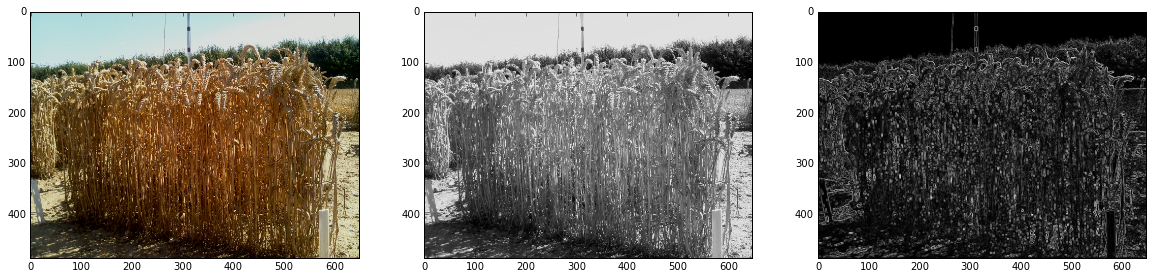

In [12]:
# Sample images     
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows = 1, figsize = (20, 20))
ax1.imshow(imageResize)
ax2.imshow(tmp_value, cmap = 'gray')
ax3.imshow(image_sobel, cmap = 'gray') 

In [13]:
# End of the algorithm
# Version control and comments should be updated in bitbucket 